In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece
!pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 718.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import custom module

In [ ]:
%cd /content/drive/MyDrive/ITMO/T5QA/src
%ls

/content/drive/MyDrive/ITMO/T5QA/src
medqadataset.py  __pycache__/  trainer.py


In [ ]:
from medqadataset import MedQADataset
import trainer

In [ ]:
# # For debugging
# import importlib
# importlib.reload(trainer)

<module 'trainer' from '/content/drive/MyDrive/ITMO/T5QA/src/trainer.py'>

In [ ]:
# Extract sum for context, abstract for answers, answers: 200 tokens

#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_context_answ_sum2"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
DEVICE

'cpu'

### Read Data

In [ ]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_context_answer_sum_clean.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляет...,кератодермия с пушистыми волосами представляет...
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляет...,кератодермия с пушистыми волосами встречается ...
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляет...,"гены, которые приводят к кератодермии с пушист..."
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляет...,кератодермия с курчавыми волосами имеет аутосо...
4,что такое синдром кноблоха?,"изза аномалий стекловидного тела, сетчатки и м...","в сша диагностирован синдром кноблоха, характе..."
...,...,...,...
1100,есть ли у вас информация об измерении темпера...,оставьте термометр во рту на 3 минуты или пока...,"если температура тела может быть высока, то эт..."
1101,что такое дефицит аденозинмонофосфатдезаминаз...,у многих больных дефицит амфдезаминазы не вызы...,"ученые считают, что дефицит амфдезаминазы може..."
1102,сколько людей страдают от дефицита аденозинмо...,у многих больных дефицит амфдезаминазы не вызы...,амфдезаминазы является одним из наиболее распр...
1103,"каковы генетические изменения, связанные с де...",у многих больных дефицит амфдезаминазы не вызы...,человек с дефицитом амфдезаминазы страдает от ...


### Example

In [ ]:
sample = data.iloc[5]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [ ]:
output.loss

tensor(83.7994, grad_fn=<NllLossBackward0>)

In [ ]:
sample_q = data.iloc[5]["question"]
sample_a = data.iloc[5]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [ ]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [ ]:
" ".join(preds)

' сколько люд ей страда ет си ндром ом кн обл оха ?  си ндром кн обл оха ред кое заболевани е ,  о днако распростран енность это го заболевани я не известн а .  точная распростран енность  и распростран енность синд рома не известн ы .  точные распростран енность заболевани я пока не известно а . '

### Dataloaders

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (865, 3)
Validation shape: (217, 3)
Test shape: (23, 3)


### Train and validation loop

In [ ]:
N_EPOCHS = 25
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_context_answ_sum2'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [ ]:
trainer_module.model.config

T5Config {
  "_name_or_path": "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_context_answ_sum2",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.35.2",
  "use_cache": true,
  "vocab_size": 30000
}

In [ ]:
trainer_module.fit()

Validation batches: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch: 0		Train loss: 0.17009486261463386		Validation loss: 0.008580050395473583


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch: 1		Train loss: 0.16560689191664418		Validation loss: 0.008795157276009295


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch: 2		Train loss: 0.16161686551117677		Validation loss: 0.009181668520481748


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch: 3		Train loss: 0.14816555361937267		Validation loss: 0.007571895586178553


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch: 4		Train loss: 0.1441566318376548		Validation loss: 0.0067039847458628095


Validation batches: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch: 5		Train loss: 0.13543644617848133		Validation loss: 0.006265243061352521


Validation batches:  22%|██▏       | 12/55 [00:02<00:10,  4.17it/s]

### Evaluate results

In [ ]:
test_sample = test_data.iloc[7]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"Ответ: {test_sample['answer']}"

test_question

pred = trainer_module.predict_answer(
    test_context,
    test_question,
    test_answer,
    print_text=True
)

pred

Контекст: отек стоп, голеней и лодыжек часто встречается, когда человек также: имеет лишний вес имеет тромб в ноге пожилой имеет инфекцию ног имеет вены на ногах, которые не могут правильно перекачивать кровь обратно к сердцу так называемая венозная недостаточность, чаще всего изза варикозного расширения вен. травма или операция на ноге, лодыжке или стопе также могут вызвать отек. длительные перелеты на самолете или поездки на автомобиле, а также длительное стояние часто приводят к некоторому отеку стоп и лодыжек. отек может возникнуть у женщин, принимающих эстроген или во время частей менструального цикла. немедленно обратитесь к своему врачу, если: у вас заболевание сердца или почек, и отек усиливается. у вас в анамнезе заболевание печени, и теперь у вас отек ног или живота. вы беременны, и у вас наблюдается нечто большее, чем просто небольшой отек, или внезапное увеличение отека. у вас появился новый или усилившийся отек только на одной ноге. также обратитесь к своему врачу, если ме

{'Reference Answer: ': 'Ответ: отеки стоп и лодыжек распространенная проблема, особенно среди пожилых людей. аномальное скопление жидкости в ступнях и стопах может вызвать отек стоп. это может привести к осложнениям, в том числе и к тяжелым заболеваниям.',
 'Predicted Answer: ': 'Ответ: отеки стоп и лодыжек распространенная проблема, особенно среди пожилых людей. аномальное скопление жидкости в ступнях и стопах может вызвать отек стоп. это может привести к осложнениям, в том числе и к тяжелым заболеваниям.',
 'BLEU Score: ': {'google_bleu': 1.0},
 'RougeL (precision): ': 1.0}

In [ ]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.7686465610848674
RougeL: 0.8080206749771968


In [ ]:
trainer_module.plot_loss()

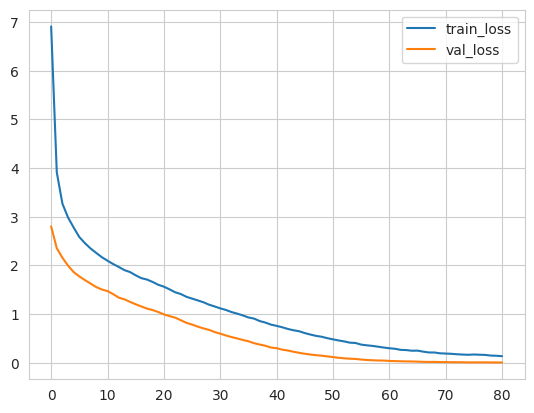

In [ ]:
loss_filepath = "/content/drive/MyDrive/ITMO/T5QA/data/loss_context_answ_200_sum"
# Plot loss
trainer_module.plot_loss(filepath=loss_filepath)

### Inference

In [ ]:
test_sample = test_data.iloc[20]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое есть мочеиспускание затруднение с потоком? также называется: задержка мочеиспускания; нерешительность; трудности с началом мочеиспускания
Контекст: почти у всех пожилых мужчин возникают проблемы с подтеканием мочи, слабой струей мочи и началом мочеиспускания. лекарства, используемые при недержании, а также некоторые витамины и пищевые добавки расстройства нервной системы или проблемы со спинным мозгом побочные эффекты хирургического вмешательства рубцовая ткань стриктура в трубке, ведущей из мочевого пузыря уретры спастические мышцы таза уход на дому действия, при которых можно позаботиться включите себе: следите за своим характером мочеиспускания и приносите отчет своему врачу. когда следует обращаться к медицинскому работнику позвоните своему врачу, если вы заметите задержку мочеиспускания, подтекание или слабую струю мочи. немедленно позвоните своему врачу, если: у вас жар, рвота, побочный эффект или боль в спине, озноб или мало мочи в течение 12 дней. у вас кровь

In [ ]:
test_sample = test_data.iloc[18]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое деменция уход на дому? также называется: уход за человеком, страдающим деменцией; уход на дому деменция
Контекст: . регулярные прогулки с лицом, осуществляющим уход, могут помочь улучшить коммуникативные навыки и предотвратить блуждание. людям с деменцией следует проверить зрение и слух. люди с деменцией часто забывают есть и пить и в результате могут страдать обезвоживанием. если они заблудятся, их опекун может связаться с полицией и национальным офисом безопасного возвращения, где информация о них хранится и распространяется по всей стране. в конечном итоге людям с деменцией может потребоваться круглосуточное наблюдение и помощь, чтобы обеспечить безопасную среду, контролировать агрессивное или возбужденное состояние. долгосрочный уход человеку с деменцией может потребоваться наблюдение и помощь дома или в учреждении. возможные варианты включают: дневной уход за взрослыми домаинтернаты дома престарелых уход на дому существует множество организаций, которые могут по

In [ ]:
test_sample = test_data.iloc[7]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое отек стопы, голени и лодыжки? также называется: отек лодыжек ступней ног; отек лодыжек; отек стоп; отек ног; отек периферический; периферический отек
Контекст: отек стоп, голеней и лодыжек часто встречается, когда человек также: имеет лишний вес имеет тромб в ноге пожилой имеет инфекцию ног имеет вены на ногах, которые не могут правильно перекачивать кровь обратно к сердцу так называемая венозная недостаточность, чаще всего изза варикозного расширения вен. травма или операция на ноге, лодыжке или стопе также могут вызвать отек. длительные перелеты на самолете или поездки на автомобиле, а также длительное стояние часто приводят к некоторому отеку стоп и лодыжек. отек может возникнуть у женщин, принимающих эстроген или во время частей менструального цикла. немедленно обратитесь к своему врачу, если: у вас заболевание сердца или почек, и отек усиливается. у вас в анамнезе заболевание печени, и теперь у вас отек ног или живота. вы беременны, и у вас наблюдается нечто бол

In [ ]:
test_sample = test_data.iloc[11]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: каковы генетические изменения, связанные с синдромом мабри?
Контекст: синдром мабри это состояние, характеризующееся умственной отсталостью, характерными чертами лица, повышенным уровнем фермента, называемого щелочной фосфатазой, в крови гиперфосфатазия и другими признаками и симптомами. гиперфосфатазия начинается в течение первого года жизни у людей с синдромом мабри. у больных уровень щелочной фосфатазы в крови обычно увеличивается в одиндва раза по сравнению с нормой, но может быть до 20 раз выше нормы. причины мутации в генах pigv, pigo или pgap2 вызывают синдром мабри. белки, у которых отсутствует функциональный якорь gpi, не могут связываться с клеточной мембраной и вместо этого высвобождаются из клетки. высвобождение щелочной фосфатазы, не связанной с gpi, повышает количество этого белка в крови, вызывая гиперфосфатазию у людей с синдромом мабри. неясно, как мутации генов приводят к другим особенностям синдрома мабри, но эти признаки и симптомы, вероятно, связаны с отсут

In [ ]:
test_context = f"Контекст: Холецистит является воспалительным процессом, который возникает в желчном пузыре. От этой патологии сегодня страдает около 20% жителей всего мира. Причем наиболее подвержены заболеванию женщины старше 50 лет. Воспаление выявляют у людей и другого возраста. Причем для детей и подростков характерна бескаменная форма. Зачастую болезнь диагностируется в развитых странах. Обусловлено это особым образом жизни и пищевым поведением."
test_question = f"Вопрос: Что такое холецистит?"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: Что такое холецистит?
Контекст: Холецистит является воспалительным процессом, который возникает в желчном пузыре. От этой патологии сегодня страдает около 20% жителей всего мира. Причем наиболее подвержены заболеванию женщины старше 50 лет. Воспаление выявляют у людей и другого возраста. Причем для детей и подростков характерна бескаменная форма. Зачастую болезнь диагностируется в развитых странах. Обусловлено это особым образом жизни и пищевым поведением.
Ответ: холецистит это воспалительный процесс, который возникает в желчном пузыре. это может быть связано с тяжелыми заболеваниями, которые могут появиться у людей старше 50 лет. если заболевание появляется у женщин, то его можно будет лечить уже в следующем десятилетии.
